# Define functions

In [1]:
import warnings

import numpy as np

from sklearn.datasets.base import Bunch
from nilearn.datasets.utils import _get_dataset_dir, _fetch_files


def fetch_data(n_subjects=30, data_dir=None, url=None, resume=True,
               verbose=1):
    """Download and load the dataset.

    Parameters
    ----------
    n_subjects: int, optional
        The number of subjects to load from maximum of 40 subjects.
        By default, 30 subjects will be loaded. If None is given,
        all 40 subjects will be loaded.

    data_dir: string, optional
        Path of the data directory. Used to force data storage in a specified
        location. Default: None

    url: string, optional
        Override download URL. Used for test only (or if you setup a mirror of
        the data). Default: None

    Returns
    -------
    data: sklearn.datasets.base.Bunch
        Dictionary-like object, the interest attributes are :
         - 'func': Paths to functional resting-state images
         - 'phenotypic': Explanations of preprocessing steps
         - 'confounds': CSV files containing the nuisance variables

    References
    ----------
    :Download:
        https://openneuro.org/datasets/ds000228/versions/00001

    """

    if url is None:
        url = 'https://openneuro.org/crn/datasets/ds000228/snapshots/00001/files/'

    # Preliminary checks and declarations
    dataset_name = 'ds000228'
    data_dir = _get_dataset_dir(dataset_name, data_dir=data_dir,
                                verbose=verbose)
    max_subjects = 155
    if n_subjects is None:
        n_subjects = max_subjects
    if n_subjects > max_subjects:
        warnings.warn('Warning: there are only %d subjects' % max_subjects)
        n_subjects = max_subjects
    ids = range(1, n_subjects + 1)

    # First, get the metadata
    phenotypic = (
            'participants.tsv',
            url + 'participants.tsv', dict())

    phenotypic = _fetch_files(data_dir, [phenotypic], resume=resume,
                              verbose=verbose)[0]

    # Load the csv file
    phenotypic = np.genfromtxt(phenotypic, names=True, delimiter='\t',
                               dtype=None)

    # Keep phenotypic information for selected subjects
    int_ids = np.asarray(ids, dtype=int)
    phenotypic = phenotypic[[i - 1 for i in int_ids]]

    # Download dataset files

    functionals = [
        'derivatives:fmriprep:sub-pixar%03i:sub-pixar%03i_task-pixar_run-001_swrf_bold.nii.gz' % (i, i)
        for i in ids]
    urls = [url + name for name in functionals]
    functionals = _fetch_files(
        data_dir, zip(functionals, urls, (dict(),) * n_subjects),
        resume=resume, verbose=verbose)

    confounds = [
        'derivatives:fmriprep:sub-pixar%03i:sub-pixar%03i_task-pixar_run-001_ART_and_CompCor_nuisance_regressors.mat'
        % (i, i)
        for i in ids]
    confound_urls = [url + name for name in confounds]

    confounds = _fetch_files(
        data_dir, zip(confounds, confound_urls, (dict(),) * n_subjects),
        resume=resume, verbose=verbose)

    return Bunch(func=functionals, confounds=confounds,
                 phenotypic=phenotypic, description='ds000228')



//anaconda/envs/nilearn_tutorial/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Confounds function

import h5py
import numpy as np

def prepare_confounds(conf, key = 'R', transpose=True):
    arrays = {}
    f = h5py.File(conf)
    for k, v in f.items():
        arrays[k] = np.array(v)
    
    if transpose:
        output = arrays[key].T
    else:
        output = arrays[key]
    
    return output

In [3]:
import os
import numpy as np
import nibabel as ni
from nilearn.input_data import NiftiLabelsMasker
from nilearn.connectome import ConnectivityMeasure
from nilearn.image import resample_img

def extract_data(atlas_filename, data, downsampling_args = {},
                 save_dir = './', filename = 'features',
                verbose = False):

    masker = NiftiLabelsMasker(labels_img=atlas_filename, 
                               standardize=True, 
                               memory='nilearn_cache', 
                               verbose=0)
    correlation_measure = ConnectivityMeasure(kind='correlation', 
                                              vectorize=True,
                                             discard_diagonal=True)
    
    all_features = []
    if downsampling_args:
        print('downsampling...')
        for i,sub in enumerate(data.func):
            conf = prepare_confounds(data.confounds[i])
            nimg = reduce_data(sub, downsampling_args['target_shape'],
                              downsampling_args['target_affine'],
                              downsampling_args['target_type'])
            time_series = masker.fit_transform(nimg, confounds=conf)
            correlation_matrix = correlation_measure.fit_transform([time_series])[0]
            all_features.append(correlation_matrix)
            if verbose:
                print('finished %s of %s'%(i+1,len(data.func)))
    else:
        for i,sub in enumerate(data.func):
            conf = prepare_confounds(data.confounds[i])
            time_series = masker.fit_transform(sub, confounds=conf)
            correlation_matrix = correlation_measure.fit_transform([time_series])[0]
            all_features.append(correlation_matrix)
            if verbose:
                print('finished %s of %s'%(i+1,len(data.func)))
            
    savefile = os.path.join(save_dir, filename)
    np.savez_compressed(savefile, a = all_features)
    
    return savefile
    
def reduce_data(img_path, target_shape, target_affine,
                target_type = np.float32):
    
    img = ni.load(img_path)
    nimg = resample_img(img, target_affine, target_shape)
    nimg = ni.Nifti1Image(nimg.get_data().astype(target_type),
                         nimg.affine)
    return nimg

In [4]:
from sklearn.model_selection import cross_val_predict, cross_val_score, train_test_split
from sklearn.metrics import r2_score, mean_absolute_error

def do_machine_learning(clf, X, y, groups, subsample_rate = 1., 
                        repetitions = 10, cv=10):
    
    cv_r2s = []
    cv_maes = []
    t_r2s = []
    t_maes = []
    indices = []
    for i in range(repetitions):
        if subsample_rate<1:
            ss_X, _0, ss_y, _1, ss_groups, _2 = train_test_split(X, y, groups,
                                                                test_size = 1-subsample_rate, 
                                                                shuffle = True,
                                                                stratify = groups,
                                                                )
        else:
            ss_X, ss_y, ss_groups = X, y, groups
        X_train,X_test,y_train,y_test,group_train,group_test = train_test_split(
                                                                ss_X, ss_y, 
                                                                ss_groups,
                                                                test_size = 0.4, 
                                                                shuffle = True,
                                                                stratify = ss_groups,
                                                                random_state = 123
                                                                                )
        indices.append(ss_y.index)
        r2, mae = training_cv(clf, X_train, y_train, group_train, cv)
        cv_r2s.append(r2)
        cv_maes.append(mae)
        
        r2, mae = testing(clf, X_train, y_train, X_test, y_test)
        t_r2s.append(r2)
        t_maes.append(mae)
        
        
    results = dict(zip(['mean_cv_r2', 'mean_cv_mae', 
                        'mean_test_r2', 'mean_test_mae', 
                        'max_cv_r2', 'min_cv_mae',
                        'max_test_r2', 'min_test_mae'],
                      [np.mean(cv_r2s), np.mean(cv_maes), 
                       np.mean(t_r2s), np.mean(t_maes),
                       np.max(cv_r2s), np.min(cv_maes),
                       np.max(t_r2s), np.min(t_maes)]))
    evals = [(t_r2s[x] + cv_r2s[x])/2 for x in range(repetitions)]
    best_test = np.argmax(evals)
    best_index = indices[best_test]
    print(results)
        
    return results, best_index
    
def training_cv(clf, X_train, y_train, groups, cv=10):
    
    # predict
    y_pred = cross_val_predict(clf, X_train, y_train, groups, cv)
    # scores
    r2 = r2_score(y_pred = y_pred, y_true = y_train)
    mae = mean_absolute_error(y_pred = y_pred, y_true = y_train)
    
    return r2, mae
    
    
def testing(clf, X_train, y_train, X_test, y_test):
    
    clf.fit(X_train, y_train) # fit to training data
    y_pred = clf.predict(X_test) # predict age using testing data
    r2 = clf.score(X_test, y_test) # get r2 score
    mae = mean_absolute_error(y_pred=y_pred, y_true=y_test) # get mae
    
    return r2, mae

# Prepare data

In [5]:
wdir = '/Users/jakevogel/Science/Nilearn_tutorial/ds000028/'
data = fetch_data(None,data_dir=wdir)

//anaconda/envs/nilearn_tutorial/lib/python3.6/site-packages/ipykernel_launcher.py:68: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.


In [6]:
from nilearn import datasets
multiscale = datasets.fetch_atlas_basc_multiscale_2015()
atlas_filename = multiscale.scale064

In [7]:
import pandas

pheno = pandas.DataFrame(data.phenotypic)
y = np.log(pheno['Age'])
ageGroups = pheno.AgeGroup 

In [8]:
cols = ['resolution', 'sampling_rate', 'mean_cv_r2', 'mean_cv_mae', 
        'mean_test_r2', 'mean_test_mae', 'max_cv_r2', 'min_cv_mae',
       'max_test_r2', 'min_test_mae']
df = pandas.DataFrame(columns = cols)

# Run analyses

In [18]:
from sklearn.svm import SVR

ex = ni.load(data.func[0])

clf = SVR(kernel='linear')
g_indices = []
k = 0
for reduction in range(1,6):
    if reduction == 1:
        downsampling_args = {}
        factor = 2
    else:
        sshape = [int(round(x)) for x in np.array(ex.shape[:3]
                                                 ) / reduction]
        #downsampling_args.update({'target_shape': sshape})
        downsampling_args.update({'target_shape': None})
        aff_mat = ex.affine
        factor = 2+(reduction-1)
        aff_mat[0,0] = factor*-1
        aff_mat[1,1] = factor
        aff_mat[2,2] = factor
        downsampling_args.update({'target_affine': aff_mat})
        downsampling_args.update({'target_type': np.float32})
    print('>>>>>>>>working on %smm data'%factor)
    print('extracting')
    savefile = '%smm_features'%factor
    #savefile = extract_data(atlas_filename, data, 
    #                          downsampling_args = downsampling_args,
    #                          save_dir = './', 
    #                          filename = '%smm_features'%factor,
    #                          verbose = False)
    X = np.load(savefile+'.npz')['a']
    print('learning')
    for sampling_rate in [1.,0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2]:
        print('====sampling at %s%%===='%sampling_rate)
        results, g_index = do_machine_learning(clf, X, y, ageGroups, 
                                               subsample_rate = sampling_rate, 
                                                repetitions = 20, cv=10)
        g_indices.append(g_index)
        df.loc[k,'resolution'] = factor
        df.loc[k,'sampling_rate'] = sampling_rate
        df.loc[k, df.columns[2:]] = pandas.DataFrame.from_dict(results, orient='index'
                                                        ).T.values[0]
        df.to_csv('how_low_can_we_go.csv')
        
        k+=1

# Examine output

In [140]:
img_path = data.func[0]
ds_img = reduce_data(img_path=img_path,
                     target_affine=downsampling_args['target_affine'][:3,:3],
                     target_shape = None,
                     target_type = downsampling_args['target_type'])

/Users/jakevogel/.local/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))


In [137]:
downsampling_args['target_affine'][:,3]

array([  78., -112.,  -50.,    1.])

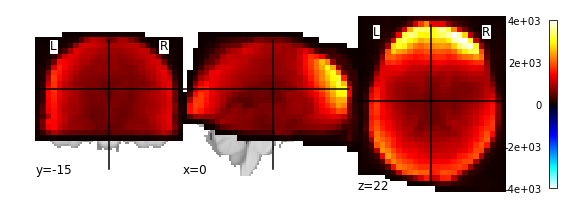

In [141]:
from nilearn import plotting
from nilearn.image import mean_img
plt.close()
plotting.plot_stat_map(mean_img(ds_img))
plt.show()

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.close()
sns.factorplot(x='sampling_rate',y='mean_test_r2', hue='resolution',
              data=df)
plt.show()

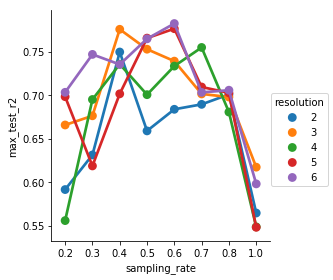

In [212]:
plt.close()
sns.factorplot(x='sampling_rate',y='max_test_r2', hue='resolution',
              data=df)
plt.show()

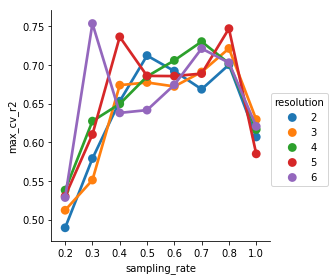

In [213]:
plt.close()
sns.factorplot(x='sampling_rate',y='max_cv_r2', hue='resolution',
              data=df)
plt.show()

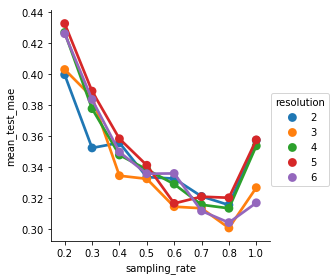

In [214]:
plt.close()
sns.factorplot(x='sampling_rate',y='mean_test_mae', hue='resolution',
              data=df)
plt.show()

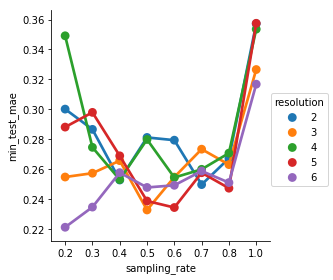

In [215]:
plt.close()
sns.factorplot(x='sampling_rate',y='min_test_mae', hue='resolution',
              data=df)
plt.show()

In [14]:
df = pandas.read_csv('how_low_can_we_go.csv',index_col=0)

In [17]:
for ssize in df.sampling_rate.unique():
    for res in df.resolution.unique():
        demo_ind = df[(df.sampling_rate==ssize) & (df.resolution==res)].index[0]
        demo_subs = g_indices[demo_ind]
        X = np.load('%smm_features.npz'%res)['a'][demo_subs.values]
        y = np.log(pheno.loc[demo_subs,'Age'])
        ageGroup = pheno.loc[demo_subs,'AgeGroup']
        
        X_train,X_test,y_train,y_test,group_train,group_test = train_test_split(
                                                        X,y, ageGroup,
                                                        test_size = 0.4, 
                                                        shuffle = True,
                                                        stratify = ageGroup,
                                                        random_state = 123
                                                                        )
        y_pred = cross_val_predict(clf, X_train, y_train, group_train, 10)
            # scores
        r2 = r2_score(y_pred = y_pred, y_true = y_train)
        mae = mean_absolute_error(y_pred = y_pred, y_true = y_train)
        print('>>>SIZE=%s,RES=%smm<<<'%(ssize,res))
        print('validation r2: %s'%r2)
        print('validation mae: %s'%mae)

        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test) 
        r2 = clf.score(X_test, y_test)
        mae = mean_absolute_error(y_pred=y_pred, y_true=y_test)
        print('test r2: %s'%r2)
        print('test mae: %s'%mae)


>>>SIZE=1.0,RES=2mm<<<
validation r2: 0.6067900892749318
validation mae: 0.3171767357183989
test r2: 0.5645052266954728
test mae: 0.35719953873825666
>>>SIZE=1.0,RES=3mm<<<
validation r2: 0.6293467027252573
validation mae: 0.31071484308342184
test r2: 0.6171726624530482
test mae: 0.3265798917844498
>>>SIZE=1.0,RES=4mm<<<
validation r2: 0.61647637945984
validation mae: 0.314381028704409
test r2: 0.548596122684469
test mae: 0.35356228431460035
>>>SIZE=1.0,RES=5mm<<<
validation r2: 0.5849778040777571
validation mae: 0.3287474902604423
test r2: 0.548090452838556
test mae: 0.3574662847157747
>>>SIZE=1.0,RES=6mm<<<
validation r2: 0.6204414624378485
validation mae: 0.3135354612829246
test r2: 0.5979730221894721
test mae: 0.31680104488865984
>>>SIZE=0.8,RES=2mm<<<
validation r2: 0.7537006294097754
validation mae: 0.25569377931027526
test r2: 0.6377540806595507
test mae: 0.3039981949510079
>>>SIZE=0.8,RES=3mm<<<
validation r2: 0.76711839732992
validation mae: 0.24796474054677317
test r2: 0.5897

# Estimate size

In [229]:
from subprocess import check_output
output = check_output('ls -lrth ~/Science/Nilearn_tutorial/ds000028/ds000228/*.nii.gz',
                      shell=True)

In [246]:
sizes = [str(output).split('M Sep')[x][-2:] for x in range(len(str(output).split('M Sep')))]
sizes = [int(x) for x in sizes if x.isnumeric()]
len(sizes)

155

In [252]:
from math import isclose
[x for x in range(len(sizes)) if isclose(sizes[x],np.mean(sizes),abs_tol=1)] 

[34, 37, 41, 43, 46, 48, 51, 52, 56, 59, 66, 70, 90, 97, 101, 102, 108]

In [253]:
print(np.mean(sizes), sizes[34])

81.90967741935484 82


In [255]:
from nilearn.image import crop_img

size_test_ind = 34
size_test_sub = data.func[34]

for reduction in range(2,6):
    sshape = [int(round(x)) for x in np.array(ex.shape[:3]
                                             ) / reduction]
    #downsampling_args.update({'target_shape': sshape})
    downsampling_args.update({'target_shape': None})
    aff_mat = ex.affine
    factor = 2+(reduction-1)
    aff_mat[0,0] = factor*-1
    aff_mat[1,1] = factor
    aff_mat[2,2] = factor
    downsampling_args.update({'target_affine': aff_mat})
    downsampling_args.update({'target_type': np.float32})
    ds_img = reduce_data(img_path=size_test_sub,
                     target_affine=downsampling_args['target_affine'][:3,:3],
                     target_shape = None,
                     target_type = downsampling_args['target_type'])
    ds_img = crop_img(ds_img)
    ds_img.to_filename('development/%smm_test_sub'%factor)
    print('finished',factor)

/Users/jakevogel/.local/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/Users/jakevogel/.local/lib/python3.6/site-packages/nilearn/image/image.py:314: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cropped_data = data[slices]


finished 3


/Users/jakevogel/.local/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/Users/jakevogel/.local/lib/python3.6/site-packages/nilearn/image/image.py:314: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cropped_data = data[slices]


finished 4


/Users/jakevogel/.local/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/Users/jakevogel/.local/lib/python3.6/site-packages/nilearn/image/image.py:314: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cropped_data = data[slices]


finished 5


/Users/jakevogel/.local/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/Users/jakevogel/.local/lib/python3.6/site-packages/nilearn/image/image.py:314: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cropped_data = data[slices]


finished 6


In [259]:
output = check_output('ls -lrth /Users/jakevogel/git/RS2018_Nilearn_tutorial/development/*.nii',
                      shell=True)
output

b'-rw-r--r--  1 jakevogel  staff   100M Oct  1 16:58 /Users/jakevogel/git/RS2018_Nilearn_tutorial/development/3mm_test_sub.nii\n-rw-r--r--  1 jakevogel  staff    43M Oct  1 16:58 /Users/jakevogel/git/RS2018_Nilearn_tutorial/development/4mm_test_sub.nii\n-rw-r--r--  1 jakevogel  staff    23M Oct  1 16:58 /Users/jakevogel/git/RS2018_Nilearn_tutorial/development/5mm_test_sub.nii\n-rw-r--r--  1 jakevogel  staff    14M Oct  1 16:58 /Users/jakevogel/git/RS2018_Nilearn_tutorial/development/6mm_test_sub.nii\n'

In [262]:
sizes = dict(zip(range(3,7), [100, 43, 23, 14]))
sizes

{3: 100, 4: 43, 5: 23, 6: 14}

In [32]:
# WINNERS 
print('ssize = 0.3, res=6, SIZE = %s'%((155*0.3) * 14))
print('ssize = 0.4, res=5, SIZE = %s'%((155*0.4) * 23))
print('ssize = 0.5, res=6, SIZE = %s'%((155*0.5) * 14))
print('ssize = 0.6, res=6, SIZE = %s'%((155*0.6) * 14))
print('ssize = 0.7, res=6, SIZE = %s'%((155*0.7) * 14))

ssize = 0.3, res=6, SIZE = 651.0
ssize = 0.4, res=5, SIZE = 1426.0
ssize = 0.5, res=6, SIZE = 1085.0
ssize = 0.6, res=6, SIZE = 1302.0
ssize = 0.7, res=6, SIZE = 1519.0


# Make sure it actually works at low res

#### This example uses 30% of the sample and looks at images resampled to 6mm and uses ~0.65GB

In [49]:
demo_ind = df[(df.sampling_rate==0.3) & (df.resolution==6)].index[0]
demo_subs = g_indices[demo_ind]
X = np.load('6mm_features.npz')['a'][demo_subs.values]
y = pheno.loc[demo_subs,'Age']
ageGroup = pheno.loc[demo_subs,'AgeGroup']

In [50]:
print(demo_subs.tolist())

[24, 137, 3, 113, 128, 27, 72, 121, 142, 51, 135, 97, 80, 30, 54, 84, 43, 63, 36, 53, 29, 16, 35, 74, 12, 152, 102, 62, 71, 89, 141, 105, 106, 50, 83, 145, 99, 22, 129, 124, 118, 55, 133, 9, 100, 96]


//anaconda/envs/nilearn_tutorial/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


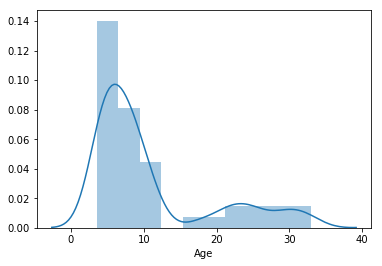

In [51]:
plt.close()
sns.distplot(y)
plt.show()

validation r2: 0.6730991187268387
validation mae: 4.2582832982173935


//anaconda/envs/nilearn_tutorial/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


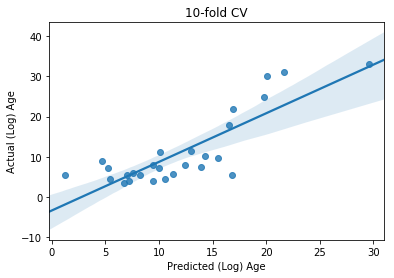

test r2: 0.5280081928722693
test mae: 4.431180944765598


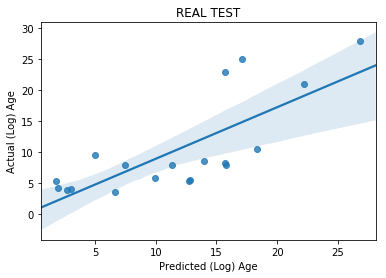

In [52]:
X_train,X_test,y_train,y_test,group_train,group_test = train_test_split(
                                                        X,y, ageGroup,
                                                        test_size = 0.4, 
                                                        shuffle = True,
                                                        stratify = ageGroup,
                                                        random_state = 123
                                                                        )
y_pred = cross_val_predict(clf, X_train, y_train, group_train, 10)
    # scores
r2 = r2_score(y_pred = y_pred, y_true = y_train)
mae = mean_absolute_error(y_pred = y_pred, y_true = y_train)
print('validation r2: %s'%r2)
print('validation mae: %s'%mae)
plt.close()
sns.regplot(x=y_pred, y=y_train)
plt.title('10-fold CV')
plt.xlabel('Predicted (Log) Age')
plt.ylabel('Actual (Log) Age')
plt.show()

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test) 
r2 = clf.score(X_test, y_test)
mae = mean_absolute_error(y_pred=y_pred, y_true=y_test)
print('test r2: %s'%r2)
print('test mae: %s'%mae)
plt.close()
sns.regplot(x=y_pred, y=y_test)
plt.title('REAL TEST')
plt.xlabel('Predicted (Log) Age')
plt.ylabel('Actual (Log) Age')
plt.show()

#### This next example uses 70% of the sample resampled to 6mm and uses ~1.5GB

In [53]:
demo_ind = df[(df.sampling_rate==0.7) & (df.resolution==6)].index[0]
demo_subs = g_indices[demo_ind]
X = np.load('6mm_features.npz')['a'][demo_subs.values]
y = pheno.loc[demo_subs,'Age']
ageGroup = pheno.loc[demo_subs,'AgeGroup']

In [54]:
print(demo_subs.tolist())

[20, 59, 22, 98, 143, 8, 1, 118, 114, 84, 9, 38, 132, 4, 80, 151, 63, 146, 137, 11, 14, 29, 69, 7, 153, 25, 136, 13, 79, 71, 31, 55, 12, 124, 10, 42, 109, 50, 34, 135, 90, 64, 52, 70, 85, 5, 142, 100, 102, 44, 32, 106, 152, 96, 119, 99, 89, 127, 101, 33, 123, 147, 72, 94, 105, 126, 49, 103, 154, 66, 128, 27, 51, 61, 6, 138, 19, 111, 115, 56, 81, 48, 120, 95, 60, 104, 15, 129, 113, 0, 67, 77, 149, 87, 37, 139, 3, 36, 83, 54, 75, 53, 140, 17, 39, 107, 150, 110]


//anaconda/envs/nilearn_tutorial/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


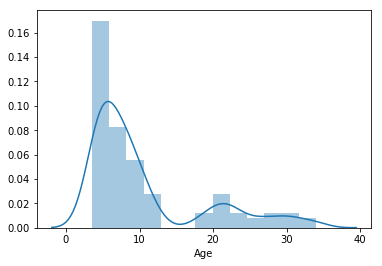

In [55]:
plt.close()
sns.distplot(y)
plt.show()

validation r2: 0.7070494096184632
validation mae: 3.513103296633346


//anaconda/envs/nilearn_tutorial/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


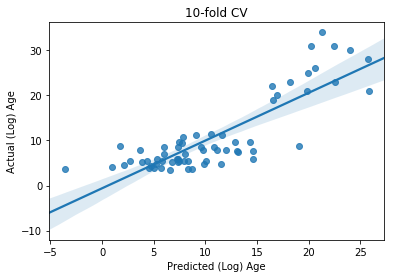

test r2: 0.4508091741724133
test mae: 4.415805499249816


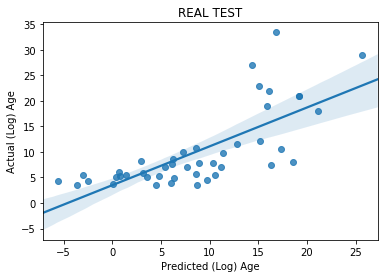

In [56]:
X_train,X_test,y_train,y_test,group_train,group_test = train_test_split(
                                                        X,y, ageGroup,
                                                        test_size = 0.4, 
                                                        shuffle = True,
                                                        stratify = ageGroup,
                                                        random_state = 123
                                                                        )
y_pred = cross_val_predict(clf, X_train, y_train, group_train, 10)
    # scores
r2 = r2_score(y_pred = y_pred, y_true = y_train)
mae = mean_absolute_error(y_pred = y_pred, y_true = y_train)
print('validation r2: %s'%r2)
print('validation mae: %s'%mae)
plt.close()
sns.regplot(x=y_pred, y=y_train)
plt.title('10-fold CV')
plt.xlabel('Predicted (Log) Age')
plt.ylabel('Actual (Log) Age')
plt.show()

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test) 
r2 = clf.score(X_test, y_test)
mae = mean_absolute_error(y_pred=y_pred, y_true=y_test)
print('test r2: %s'%r2)
print('test mae: %s'%mae)
plt.close()
sns.regplot(x=y_pred, y=y_test)
plt.title('REAL TEST')
plt.xlabel('Predicted (Log) Age')
plt.ylabel('Actual (Log) Age')
plt.show()